In [1]:
!git clone https://github.com/LINKS-Foundation-CPE/Master-QCC-2022-2023.git

Cloning into 'Master-QCC-2022-2023'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 112 (delta 49), reused 100 (delta 39), pack-reused 0
Receiving objects: 100% (112/112), 193.18 KiB | 1.20 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
!pip install pulser==0.7
!pip install pybnb
!pip install networkx==2.8.7
!pip install matplotlib==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled jsonschema-4.3.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybnb: filename=pybnb-0.6.2-py2.py3-none-any.whl size=60618 sha256=4e1699f6aa552d7ed9b9b23ffb11acb98115c2bb319fb873555f5b750ef89ad7
  Stored in directory: /root/.cache/pip/wheels/e4/00/10/d3f482061807e286001f598b8e20139454a7482912996871e5
Successfully

In [1]:
%cd /content/Master-QCC-2022-2023/

/content/Master-QCC-2022-2023


In [2]:
%matplotlib inline

In [5]:
import numpy as np

import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser_simulation import SimConfig, Simulation

from scipy.optimize import minimize, Bounds
from src.basic_MIS.utils import *

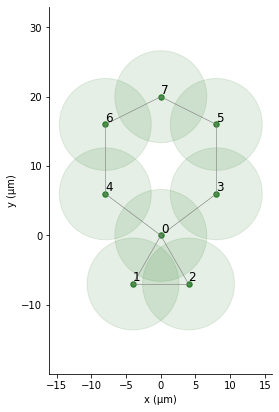

{'01011001', '00111001'}


In [6]:
# pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6]])
pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6], [8,16], [-8,16], [0,20]])
# pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6], [8,16], [-8,16], [0,20], [16,18], [-18,12]])

G = pos_to_graph(pos)
qubits = dict(enumerate(pos))

reg = Register(qubits)
reg.draw(blockade_radius=Chadoq2.rydberg_blockade_radius(1.), draw_graph=True, draw_half_radius=True ) #Assuming Rabi frequency = 1. rad/microsec

mis_ref = nx_mis(G)
print(mis_ref)

In [7]:
layers = 1
time_unit = 1000 # = 1 microsecond
detuning_amplitude = 1. # Must be between 0 and Rabi frequency, 1. is reasonable
guess = {'t': np.random.uniform(8, 10, layers),
         's': np.random.uniform(1, 3, layers)}

# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ch0','rydberg_global')

t_list = seq.declare_variable('t_list', size=layers)
s_list = seq.declare_variable('s_list', size=layers)

if layers == 1:
    t_list = [t_list]
    s_list = [s_list]

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(time_unit*t, 1., 0., 0)
    pulse_2 = Pulse.ConstantPulse(time_unit*s, 1., detuning_amplitude, 0)

    seq.add(pulse_1, 'ch0')
    seq.add(pulse_2, 'ch0')

# Bounds for max total pulse length (machine max = 100, reasonable values < 20)
max_time = 10.
step_time = max_time/layers
lb = []
ub = []
for t in t_list:
    lb.append(0.016) # minimum length of laser pulse
    ub.append(step_time*0.7)
for s in s_list:
    lb.append(0.016)
    ub.append(step_time*0.3)
np_ub = np.array(ub)
np_lb = np.array(lb)

In [8]:
def quantum_loop(parameters, draw=False, printx=False):
    if printx==True:
        print(parameters)
    t_params, s_params = 4 * (np.rint( (np.reshape(parameters, (2, layers)) * 1000) /4 ) / 1000 ) # Ensure value is multiple of 4ns
    assigned_sequence = seq.build(t_list=t_params, s_list=s_params)
    assigned_sequence.measure('ground-rydberg')
    if draw:
        assigned_sequence.draw()
    
    simul = Simulation(assigned_sequence, sampling_rate=0.1)
    results = simul.run(nsteps=1e10)
    return results.sample_final_state()

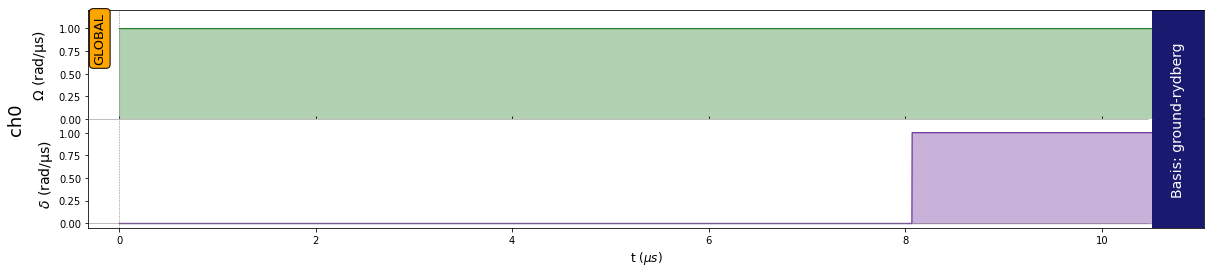

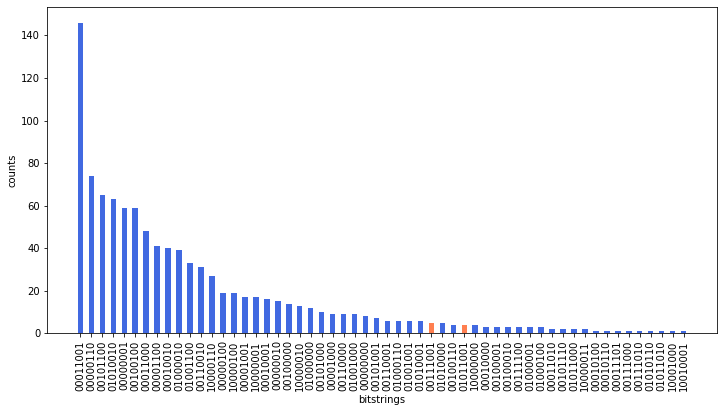

In [9]:
example_dict = quantum_loop(np.r_[guess['t'], guess['s']], draw=True)
plot_distribution(example_dict, mis_ref)

In [10]:
# MIS cost function
def get_cost_MIS(bitstring, G, penalty=1):
    z = np.array(list(bitstring), dtype=int)
    A = nx.to_numpy_matrix(G)
    # Add penalty and bias:
    cost = penalty*(z.T @ np.triu(A) @ z) - np.sum(z)
    return cost

# Cost of whole simulation with given params (averages MIS cost over many samples)
def get_cost(counter,G):
    cost = sum(counter[key] * get_cost_MIS(key,G) for key in counter)
    return cost / sum(counter.values()) # Divide by total samples

# Run simulation and get cost
def func(param,*args):
    G = args[0]
    C = quantum_loop(param);
    cost = get_cost(C,G)
    return cost

print(get_cost_MIS(list(mis_ref)[0], G)) # Cost of reference solution
print(get_cost(example_dict, G)) # Cost of examples solution

-4.0
-2.276


<ipython-input-11-a5b88029c541>:1: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(func,


[1.09999339 1.04998278]


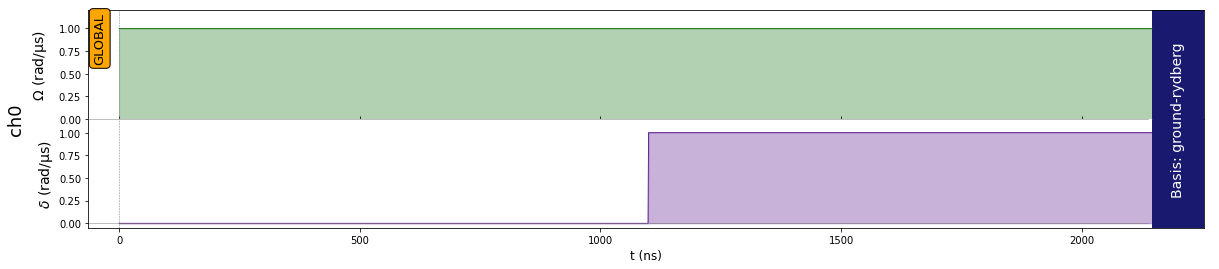

-2.782


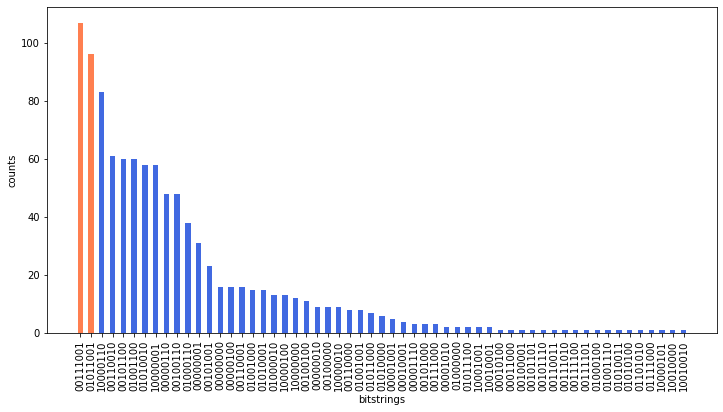

In [11]:
res = minimize(func,
               args=G,
               x0=np.array([1. for i in range(2*layers)]),
               method='Nelder-Mead',
               tol=1e-6,
            #    bounds=Bounds(np_lb,np_ub),
               options = {'maxiter': 50, 'disp': True}
              )

print(res.x)
count_dict = quantum_loop(res.x, draw=True)
print(get_cost(count_dict, G))
plot_distribution(count_dict, mis_ref)

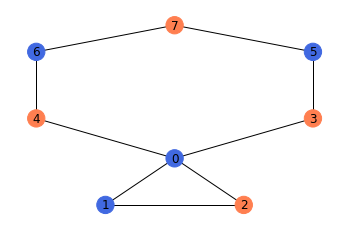

In [12]:
cmap = ['royalblue','coral']
clist = [cmap[int(c)] for c in get_mis_string(count_dict)]
f = plt.figure()
nx.draw(G, pos=pos, node_color=clist, with_labels=True, ax=f.add_subplot(111))